<a href="https://colab.research.google.com/github/aarondelgiudice/thinkful_data_bootcamp/blob/master/unit_4/lesson_3/436_Neural_Network_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network Challenge
Unit 4 / Lesson 3 / Project 6

Create a multi-layer perceptron neural network model to predict on a labeled dataset of your choosing.
Compare this model to either a boosted tree or a random forest model and describe the relative tradeoffs between complexity and accuracy.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score

## Define functions

### Confusion matrix

In [0]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

#
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
def plot_confusion_matrix_test(target, y_pred, metrics_dict):
  '''
  Plots non-normalized Confusion Matrix.
  Required inputs: target variable, predicted variable,
  and a dictionary to store result metrics.
  '''
  cnf_matrix = confusion_matrix(target, y_pred)
  metrics_dict['Test Recall metric'] = 100*cnf_matrix[1,1]/(
      cnf_matrix[1,0]+cnf_matrix[1,1])
  print("Recall metric in the test dataset: {}%".format(
      metrics_dict['Test Recall metric'])
       )
  metrics_dict['Test Precision metric'] = 100*cnf_matrix[0,0]/(
      cnf_matrix[0,0]+cnf_matrix[1,0])
  print("Precision metric in the test dataset: {}%".format(
      metrics_dict['Test Precision metric'])
       )
  # Plot non-normalized confusion matrix
  class_names = [0,1]
  plt.figure()
  plot_confusion_matrix(cnf_matrix, classes=class_names,
                        title='Test confusion matrix')
  #plt.savefig('conf_test.png')
  plt.show()

In [0]:
def plot_confusion_matrix_train(target, model, training_data, metrics_dict):
  '''
  Plots non-normalized Confusion Matrix.
  Required inputs: target variable, model, training_data,
  and a dictionary to store result metrics.
  '''
  y_pred_train = model.predict(training_data)
  cnf_matrix = confusion_matrix(target, y_pred_train)

  metrics_dict['Train Recall metric'] = 100*cnf_matrix[1,1]/(
      cnf_matrix[1,0]+cnf_matrix[1,1])
  print("Recall metric in the train dataset: {}%".format(
      metrics_dict['Train Recall metric'])
       )
  metrics_dict['Train Precision metric'] = 100*cnf_matrix[0,0]/(
      cnf_matrix[0,0]+cnf_matrix[1,0])
  print("Precision metric in the train dataset: {}%".format(
      metrics_dict['Train Precision metric'])
       )
  # Plot non-normalized confusion matrix
  class_names = [0,1]
  plt.figure()
  plot_confusion_matrix(cnf_matrix ,classes=class_names,
                        title='Training Confusion matrix')
  #plt.savefig('conf_train.png')
  plt.show()

### ROC Curve

In [0]:
def plot_ROC_curve(target, y_pred, metrics_dict, TITLE='ROC Curve'):
  '''
  Plots ROC curve.
  Required inputs: target variable, predicted variable,
  and a dictionary to store result metrics.
  Optional inputs: title for plot (recommended: model type, ie. Decision Tree) 
  '''
  #
  from sklearn.metrics import roc_curve, roc_auc_score
  # calculate AUC
  metrics_dict['ROC-AUC'] = roc_auc_score(target, y_pred)
  print('ROC-AUC: %.3f' % metrics_dict['ROC-AUC'])
  # calculate roc curve
  fpr, tpr, thresholds = roc_curve(target, y_pred)

  # plot no skill
  plt.plot([0, 1], [0, 1], linestyle='--')
  # plot the roc curve for the model
  plt.plot(fpr, tpr, marker='.', label='ROC Curve')
  plt.title(TITLE)
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.legend()
  #plt.savefig('ROC_curve.png')
  plt.show()

### Precision-Recall Curve

In [0]:
def plot_precision_recall(target, y_pred, metrics_dict,
                          TITLE='Precision-Recall Curve'):
  '''
  Plots Precision-Recall curve.
  Required inputs: target variable, predicted variable,
  and a dictionary to store result metrics.
  Optional inputs: title for plot (recommended: model type, ie. Decision Tree) 
  '''
  from sklearn.metrics import precision_recall_curve, auc
  from sklearn.metrics import average_precision_score, f1_score
  # calculate precision-recall curve
  precision, recall, thresholds = precision_recall_curve(target, y_pred)
  # calculate F1 score
  metrics_dict['F1 score'] = f1_score(target, y_pred)
  # calculate precision-recall AUC
  metrics_dict['Precision-Recall AUC'] = auc(recall, precision)
  # calculate average precision score
  metrics_dict['Average Precision'] = average_precision_score(target, y_pred)
  print('f1=%.3f auc=%.3f ap=%.3f' % (metrics_dict['F1 score'],
                                      metrics_dict['Precision-Recall AUC'],
                                      metrics_dict['Average Precision']))
  # plot no skill
  plt.plot([0, 1], [0.5, 0.5], linestyle='--')
  # plot the precision-recall curve for the model
  plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
  plt.title(TITLE)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.legend()
  #plt.savefig('precision_recall_curve.png')
  plt.show()

### Metrics

In [0]:
def view_dict_items(dictionary, TITLE='Title'):
  '''
  Prints items from a dictionary.
  Required inputs: dictionary.
  Optional inputs: title. 
  '''
  # view items
  print(TITLE)
  for item in dictionary.items():
    print(item)

## Load data

In [2]:
#
IS_LOCAL = False
#
filename = 'creditcard.csv'
#
if IS_LOCAL == True:
  PATH = r'assets/'
  df = pd.read_csv(PATH + filename)
else:
  from google.colab import files
  uploaded = files.upload()
  import io
  df = pd.read_csv(io.BytesIO(uploaded[filename]))

df.head()

Saving creditcard.csv to creditcard.csv


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## EDA

In [9]:
df.shape

(284807, 31)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [11]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [12]:
# view sum of NaN values
df.isna().sum().sum()

0

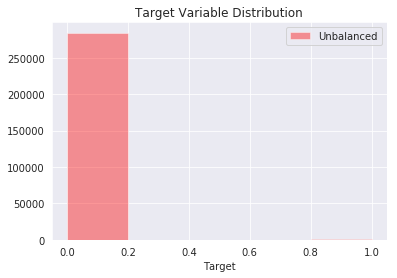

Target variable count: 492 out of 284807 total samples
Target variable percent: 0.1727485630620034%


In [13]:
plt.figure(figsize=(6,4))
plt.title("Target Variable Distribution")
sns.distplot(df['Class'], color="red", kde=False,bins=5, label='Unbalanced')
plt.legend()
plt.xlabel('Target')
#plt.savefig('')
plt.show()

print('Target variable count: {} out of {} total samples'.format(
    df.Class.sum(), len(df)))
print('Target variable percent: {}%'.format(df.Class.sum()/len(df)*100))

## Feature Selection

### Train, test, split

In [0]:
Data = df.drop('Class', axis=1)
target = df.Class

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    Data, target, test_size=0.2, random_state=42)

### Check for correlation

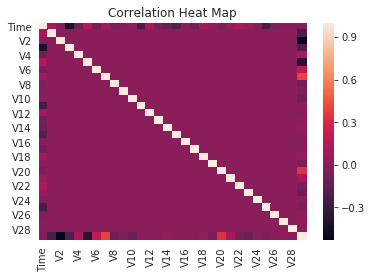

CPU times: user 873 ms, sys: 205 ms, total: 1.08 s
Wall time: 861 ms


In [15]:
%%time

# plot a heatmap
sns.heatmap(Data.corr())
plt.title('Correlation Heat Map')
#plt.savefig()
plt.show()

In [16]:
# Create correlation matrix
corr_matrix = Data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=4).astype(np.bool))

# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

display(Data.shape)

# Drop correlated features 
for i in to_drop:
    Data = Data.drop(i, axis=1)

Data.shape

(284807, 30)

(284807, 30)

### T-Test filtering

In [17]:
%%time
# define t-test filter
def ttest_filter(Data, target):
    '''
    Filters DataFrame for features with significant p-values.
    Required inputs: DataFrame of features and values, and target variable
    '''
    # import chi2_contingency
    from scipy.stats import chi2_contingency
    feature_list = []
    for feature in Data:
        cont = pd.crosstab(Data[feature], target)
        chi2_res = chi2_contingency(cont)
        # filter P-value
        if chi2_res[1] <= 0.05:
            feature_list.append(feature)
    return Data[feature_list]
            
# Filter training data
display(X_train.shape)
X_train_filt = ttest_filter(X_train, y_train)
X_test_filt = X_test[X_train_filt.columns.values]
display(X_train_filt.shape)

(227845, 30)

(227845, 30)

CPU times: user 34.9 s, sys: 304 ms, total: 35.2 s
Wall time: 35.2 s


### Balance target variable

In [27]:
%%time
print('Target variable count: {} out of {} total samples'.format(
    df.Class.sum(), len(df)))
print('Target variable percent: {}%'.format(df.Class.sum()/len(df)*100))
# import over_sampling and initiate
from imblearn import over_sampling as os
sm = os.SMOTE(random_state=42)
# save features for relabeling
features = [c for c in X_train_filt.columns]

X_train_bal, y_train_bal = sm.fit_sample(X_train_filt, y_train.ravel())
# convert to DataFrame and label columns
X_train_bal = pd.DataFrame(X_train_bal, columns=features)
y_train_bal = pd.DataFrame(y_train_bal, columns=['target'])

Target variable count: 492 out of 284807 total samples
Target variable percent: 0.1727485630620034%
CPU times: user 1.08 s, sys: 6.04 ms, total: 1.08 s
Wall time: 1.09 s


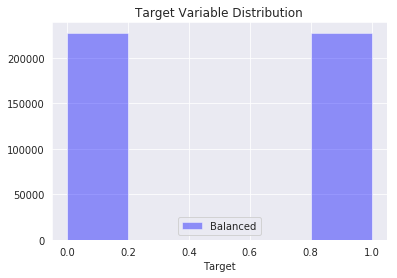

In [28]:
plt.figure(figsize=(6,4))
plt.title("Target Variable Distribution")
sns.distplot(y_train_bal,
             color="blue", kde=False,bins=5, label='Balanced')
plt.legend()
plt.xlabel('Target')
#plt.savefig()
plt.show()

### Scale data

In [29]:
%%time

# scale data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# fit transform X_train
X_train_scaled = scaler.fit_transform(X_train_bal.astype(np.float64))
# transform X_test
X_test_scaled = scaler.transform(X_test_filt)

CPU times: user 492 ms, sys: 41.1 ms, total: 533 ms
Wall time: 536 ms


### PCA

In [30]:
%%time

# import and apply PCA
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(.90)
# fit PCA on training set
X_train_pca = pca.fit_transform(X_train_scaled)
# transform test set
X_test_pca = pca.transform(X_test_scaled)
# convert numpy arrays to dataframe
X_train_pca = pd.DataFrame(X_train_pca)
X_test_pca = pd.DataFrame(X_test_pca)
#
features_pca = [c for c in X_train_pca.columns]

CPU times: user 1.61 s, sys: 322 ms, total: 1.93 s
Wall time: 1.18 s


In [31]:
# find components
print(pca.n_components_)

7


### Store clean data

In [32]:
%%time
# Clean up variable names and store data
X_train = X_train_pca
y_train = y_train_bal['target']
X_test = X_test_pca
y_test = y_test
features = features_pca

CPU times: user 593 µs, sys: 979 µs, total: 1.57 ms
Wall time: 1.58 ms


## Model Selection

### Gradient Boosted Model

In [33]:
%%time
# instantiate Light GBM Classifier
from lightgbm import LGBMClassifier
GBM = LGBMClassifier(random_state=42)
GBM.fit(X_train, y_train)
y_pred = GBM.predict(X_test)
# assign model title
Title = 'Gradient Boosted Model'

CPU times: user 6.83 s, sys: 70.2 ms, total: 6.9 s
Wall time: 3.61 s


In [34]:
%%time
# view score
print(GBM.score(X_train, y_train))
# 
print(y_train.value_counts()/len(y_train))
# 
#from sklearn.model_selection import cross_val_score
print(cross_val_score(GBM, X_train, y_train, cv=5))

0.9952297417905395
1    0.5
0    0.5
Name: target, dtype: float64
[0.99442747 0.99520774 0.99477907 0.99446032 0.99414157]
CPU times: user 34.2 s, sys: 158 ms, total: 34.4 s
Wall time: 18.4 s


In [0]:
# metrics
gbm_metrics = {}
gbm_metrics['Accuracy score'] = accuracy_score(y_test, y_pred)
gbm_metrics['Mean absolute error'] = mean_absolute_error(y_test, y_pred)
gbm_metrics['Mean squared error'] = mean_squared_error(y_test, y_pred)

Recall metric in the train dataset: 99.49967245692478%
Precision metric in the train dataset: 99.49990551817787%


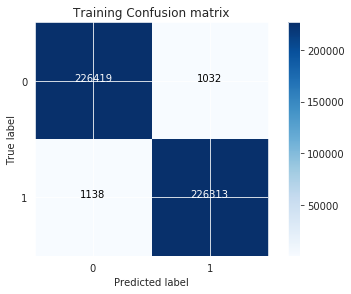

In [36]:
# plot confusion matrix on training data
plot_confusion_matrix_train(target = y_train,
                            model = GBM,
                            training_data = X_train,
                            metrics_dict = gbm_metrics)

Recall metric in the test dataset: 84.6938775510204%
Precision metric in the test dataset: 99.97349355009719%


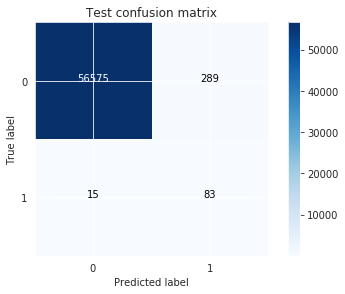

In [37]:
# plot confusion matrix on testing data
plot_confusion_matrix_test(target = y_test,
                           y_pred = y_pred,
                           metrics_dict = gbm_metrics)

ROC-AUC: 0.921


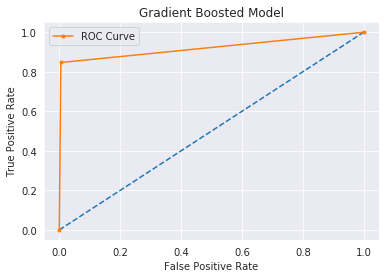

In [38]:
# plot ROC curve
plot_ROC_curve(target = y_test,
               y_pred = y_pred,
               metrics_dict = gbm_metrics,
               TITLE = Title)

f1=0.353 auc=0.535 ap=0.189


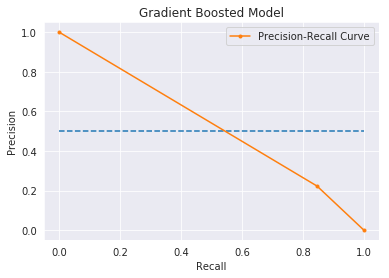

In [39]:
# plot precison-recall curve
plot_precision_recall(target = y_test,
                      y_pred = y_pred,
                      metrics_dict = gbm_metrics,
                      TITLE = Title)

In [40]:
# view metrics
view_dict_items(dictionary=gbm_metrics, TITLE=Title)

Gradient Boosted Model
('Accuracy score', 0.9946631087391594)
('Mean absolute error', 0.00533689126084056)
('Mean squared error', 0.00533689126084056)
('Train Recall metric', 99.49967245692478)
('Train Precision metric', 99.49990551817787)
('Test Recall metric', 84.6938775510204)
('Test Precision metric', 99.97349355009719)
('ROC-AUC', 0.9209282369391202)
('F1 score', 0.3531914893617022)
('Precision-Recall AUC', 0.5351601942652335)
('Average Precision', 0.18923085594323855)


### Multi-Layer Perception

In [0]:
# set parameters
# model will use default parameters for the most part 
params = {'activation': 'relu'
          'solver': 'adam'
          'alpha': 0.01
          'batch_size': 'auto'
          'learning_rate': 'constant'
          'learning_rate_init': 0.1
          # set warm_state=True
          # warm_state fits model on solution of previous call
          'warm_state': True
          # set early_stopping=True, keep tol=default
          # early_stopping will terminates training when
          # the validation score stops improving
          # requires solver='sgd' or 'adam'
          'early_stopping': True
          'tol': 1e-4
          'random_state': 42}

In [41]:
%%time
# Import the model.
from sklearn.neural_network import MLPClassifier
# set layers
LAYERS = (50, 100, 150)
# Establish and fit the model, with a single, 1000 perceptron layer.
#MLP = MLPClassifier(**params, hidden_layer_sizes=LAYERS)
MLP = MLPClassifier(hidden_layer_sizes=LAYERS)
MLP.fit(X_train, y_train)
y_pred = MLP.predict(X_test)

CPU times: user 2h 52s, sys: 21min 22s, total: 2h 22min 14s
Wall time: 1h 11min 54s


In [42]:
%%time
# view score
print(MLP.score(X_train, y_train))
# 
print(y_train.value_counts()/len(y_train))
# 
#from sklearn.model_selection import cross_val_score
print(cross_val_score(MLP, X_train, y_train, cv=5))
# assign model title
Title = 'Multi-Layer Perception'

0.9991250862823201
1    0.5
0    0.5
Name: target, dtype: float64


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:568: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:568: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:568: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:568: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:568: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


[0.99774681 0.98360079 0.96908112 0.97266432 0.97110354]
CPU times: user 43min 40s, sys: 8min 34s, total: 52min 15s
Wall time: 26min 26s


In [0]:
# metrics
mlp_metrics = {}
mlp_metrics['Accuracy score'] = accuracy_score(y_test, y_pred)
mlp_metrics['Mean absolute error'] = mean_absolute_error(y_test, y_pred)
mlp_metrics['Mean squared error'] = mean_squared_error(y_test, y_pred)

Recall metric in the train dataset: 99.9437241427824%
Precision metric in the train dataset: 99.94368898723764%


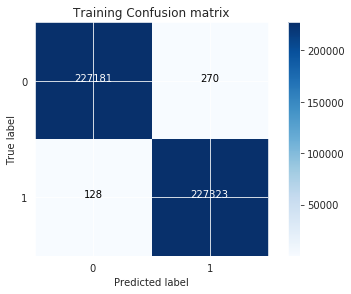

In [44]:
# plot confusion matrix on training data
plot_confusion_matrix_train(target = y_train,
                            model = MLP, 
                            training_data = X_train, 
                            metrics_dict = mlp_metrics)

Recall metric in the test dataset: 82.65306122448979%
Precision metric in the test dataset: 99.97005196864265%


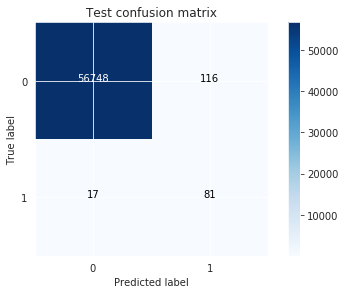

In [45]:
# plot confusion matrix on testing data
plot_confusion_matrix_test(target = y_test,
                           y_pred = y_pred, 
                           metrics_dict = mlp_metrics)

ROC-AUC: 0.912


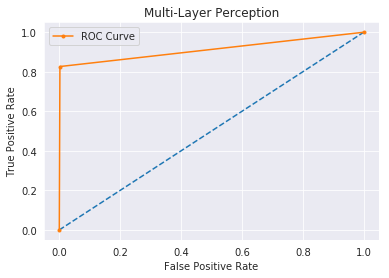

In [46]:
# plot ROC curve
Title = 'Multi-Layer Perception'
plot_ROC_curve(target = y_test,
               y_pred = y_pred, 
               metrics_dict = mlp_metrics, 
               TITLE = Title)

f1=0.549 auc=0.619 ap=0.340


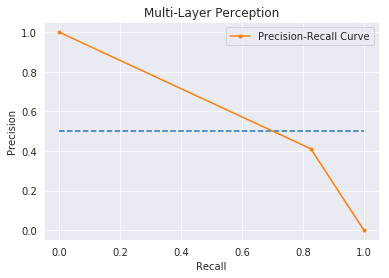

In [47]:
# plot precison-recall curve
plot_precision_recall(target = y_test,
                      y_pred = y_pred, 
                      metrics_dict = mlp_metrics,
                      TITLE = Title)

In [48]:
# view metrics
view_dict_items(dictionary=mlp_metrics, TITLE=Title)

Multi-Layer Perception
('Accuracy score', 0.9976651100733822)
('Mean absolute error', 0.0023348899266177454)
('Mean squared error', 0.0023348899266177454)
('Train Recall metric', 99.9437241427824)
('Train Precision metric', 99.94368898723764)
('Test Recall metric', 82.65306122448979)
('Test Precision metric', 99.97005196864265)
('ROC-AUC', 0.912245328632297)
('F1 score', 0.5491525423728814)
('Precision-Recall AUC', 0.6189982847561699)
('Average Precision', 0.34014098057625775)


## Conclusion
Both accounts performed well, but the MLP model took **much** longer to run.